In [1]:
%load_ext autoreload
%autoreload 2

# To load the environment variable defined in the .env file
from dotenv import load_dotenv
load_dotenv();

import os
import numpy as np
import pandas as pd
from scipy import ndimage
from scipy import stats
from scipy.ndimage import gaussian_filter 

# For progress bar
from tqdm import tqdm

# For visualization
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import plotly.graph_objects as go

import pandas as pd
from PIL import Image

import src.visualization.visualize as Viz

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [2]:
season_year = 2020
season_type = "Regular"

In [3]:
import src.data.NHLDataManager as DataManager
data_manager = DataManager.NHLDataManager()

In [4]:
data_season_df = data_manager.get_season_dataframe(season_year=season_year, season_type=season_type)

In [5]:
data_season_df.head(5)

Game ID Event Index   Time Period                       Team  Type  \
0  2020020001          35  05:12      1  Pittsburgh Penguins (PIT)  Goal   
1  2020020001          76  15:11      1  Philadelphia Flyers (PHI)  Goal   
2  2020020001         101  19:52      1  Philadelphia Flyers (PHI)  Goal   
3  2020020001         124  03:39      2  Pittsburgh Penguins (PIT)  Goal   
4  2020020001         183  18:54      2  Philadelphia Flyers (PHI)  Goal   

    Shot Type             Shooter Shooter ID         Goalie  ...    Y  \
0   Snap Shot      Mark Jankowski    8476873    Carter Hart  ... -5.0   
1      Tip-In  James van Riemsdyk    8474037  Tristan Jarry  ... -2.0   
2      Tip-In       Nolan Patrick    8479974  Tristan Jarry  ... -4.0   
3  Wrist Shot       Sidney Crosby    8471675    Carter Hart  ...  4.0   
4  Wrist Shot        Joel Farabee    8480797  Tristan Jarry  ... -4.0   

  Last event type Last event X Last event Y Last event elapsed time  \
0             Hit         55.0         42.0                    18.0   
1    Blocked Shot        -75.0         -1.0                    28.0   
2         Faceoff        -69.0         22.0                     8.0   
3        Giveaway        -96.0          7.0                     1.0   
4        Takeaway         54.0        -36.0                     4.0   

  Last event distance  st_X st_Y Last event st_X Last event st_Y  
0           53.712196  81.0 -5.0            55.0            42.0  
1            4.123106  79.0  2.0            75.0             1.0  
2           27.856777  59.0  4.0            69.0           -22.0  
3           17.262677  79.0 -4.0            96.0            -7.0  
4           43.185646  83.0 -4.0            54.0           -36.0  

[5 rows x 24 columns]

In [6]:
# Some statistics

total_shots_league = len(data_season_df)
number_of_games_season = len(data_season_df['Game ID'].unique())
print(f'Total number of shots during season {season_year} ({season_type}) = {total_shots_league}')
print(f'Number of games during season {season_year} ({season_type}) = {number_of_games_season}')

mean_shots_per_hour = total_shots_league / (2*number_of_games_season)
print(f'Mean shots by team by hour during season {season_year} ({season_type}) = {mean_shots_per_hour}')

total_goals_league = len(data_season_df[data_season_df['Type'] == 'Goal'])
mean_goals_per_hour = total_goals_league / (2*number_of_games_season)
print(f'Mean goals by team by hour during season {season_year} ({season_type}) = {mean_goals_per_hour}')

list_of_teams = data_season_df['Team'].unique()
number_of_teams = len(list_of_teams)

print(f'Number of Teams during season {season_year} ({season_type}) = {number_of_teams}')


Total number of shots during season 2020 (Regular) = 52408
Number of games during season 2020 (Regular) = 868
Mean shots by team by hour during season 2020 (Regular) = 30.1889400921659
Mean goals by team by hour during season 2020 (Regular) = 2.9815668202764978
Number of Teams during season 2020 (Regular) = 31


In [7]:
data_season_goal = data_season_df.loc[data_season_df['Type'] == 'Goal']
data_season_goal.groupby('Team').size()
data_season_goal = data_season_goal.sort_index(ascending=True)
data_season_goal.head(5)

Game ID Event Index   Time Period                       Team  Type  \
0  2020020001          35  05:12      1  Pittsburgh Penguins (PIT)  Goal   
1  2020020001          76  15:11      1  Philadelphia Flyers (PHI)  Goal   
2  2020020001         101  19:52      1  Philadelphia Flyers (PHI)  Goal   
3  2020020001         124  03:39      2  Pittsburgh Penguins (PIT)  Goal   
4  2020020001         183  18:54      2  Philadelphia Flyers (PHI)  Goal   

    Shot Type             Shooter Shooter ID         Goalie  ...    Y  \
0   Snap Shot      Mark Jankowski    8476873    Carter Hart  ... -5.0   
1      Tip-In  James van Riemsdyk    8474037  Tristan Jarry  ... -2.0   
2      Tip-In       Nolan Patrick    8479974  Tristan Jarry  ... -4.0   
3  Wrist Shot       Sidney Crosby    8471675    Carter Hart  ...  4.0   
4  Wrist Shot        Joel Farabee    8480797  Tristan Jarry  ... -4.0   

  Last event type Last event X Last event Y Last event elapsed time  \
0             Hit         55.0         42.0                    18.0   
1    Blocked Shot        -75.0         -1.0                    28.0   
2         Faceoff        -69.0         22.0                     8.0   
3        Giveaway        -96.0          7.0                     1.0   
4        Takeaway         54.0        -36.0                     4.0   

  Last event distance  st_X st_Y Last event st_X Last event st_Y  
0           53.712196  81.0 -5.0            55.0            42.0  
1            4.123106  79.0  2.0            75.0             1.0  
2           27.856777  59.0  4.0            69.0           -22.0  
3           17.262677  79.0 -4.0            96.0            -7.0  
4           43.185646  83.0 -4.0            54.0           -36.0  

[5 rows x 24 columns]

In [8]:
# Compute the number of games played for each team. Should be 82, but could be less or maybe even different for each team (COVID etc.)
df_number_of_games_by_team = data_season_df[['Team', 'Game ID']].groupby('Team').describe()['Game ID']['unique']
df_number_of_games_by_team = df_number_of_games_by_team.sort_index(ascending=True)
df_number_of_games_by_team.head(5)

Team
Anaheim Ducks (ANA)      56
Arizona Coyotes (ARI)    56
Boston Bruins (BOS)      56
Buffalo Sabres (BUF)     56
Calgary Flames (CGY)     56
Name: unique, dtype: object

In [9]:
# Total number of shots by team
df_total_shots_season_by_team = data_season_df.groupby('Team').size()
df_total_shots_season_by_team = df_total_shots_season_by_team.sort_index(ascending=True)
df_total_shots_season_by_team.head(5)

Team
Anaheim Ducks (ANA)      1509
Arizona Coyotes (ARI)    1551
Boston Bruins (BOS)      1881
Buffalo Sabres (BUF)     1610
Calgary Flames (CGY)     1694
dtype: int64

In [10]:
# Mean number of shots by team
df_mean_shots_per_team_by_hour = df_total_shots_season_by_team.sort_index(ascending=True) / df_number_of_games_by_team.sort_index(ascending=True)
df_mean_shots_per_team_by_hour.head(5)
# This is pretty consistent with https://www.statmuse.com/nhl/ask?q=nhl+team+stats+shots+per+game+2021-22

Team
Anaheim Ducks (ANA)      26.946429
Arizona Coyotes (ARI)    27.696429
Boston Bruins (BOS)      33.589286
Buffalo Sabres (BUF)         28.75
Calgary Flames (CGY)         30.25
dtype: object

In [11]:
data_one_team_df = data_season_df.loc[data_season_df['Team'] == "San Jose Sharks (SJS)"]
data_one_team_df.size

40944

In [12]:
[x_shots_season, y_shots_season] = Viz.get_shots_coordinates(data_season_df)
assert(x_shots_season.shape == y_shots_season.shape)
print(f'Mean shot coordinates = {x_shots_season.mean()}, {y_shots_season.mean()}')


Mean shot coordinates = 58.086753845214844, 0.23222066462039948


In [13]:
team = "San Jose Sharks (SJS)"
[x_shots_one_team, y_shots_one_team] = Viz.get_shots_coordinates(data_season_df, team)
assert(x_shots_one_team.shape == y_shots_one_team.shape)
print(f'Mean shot coordinates of {team} = {x_shots_one_team.mean()}, {y_shots_one_team.mean()}')


Mean shot coordinates of San Jose Sharks (SJS) = 57.911502838134766, -0.06953223794698715


In [14]:
shots_hist2D_season, x_bins, y_bins = Viz.get_shots_hist2D(x_shots_season, y_shots_season)
shots_hist2D_one_team, x_bins, y_bins = Viz.get_shots_hist2D(x_shots_one_team, y_shots_one_team)

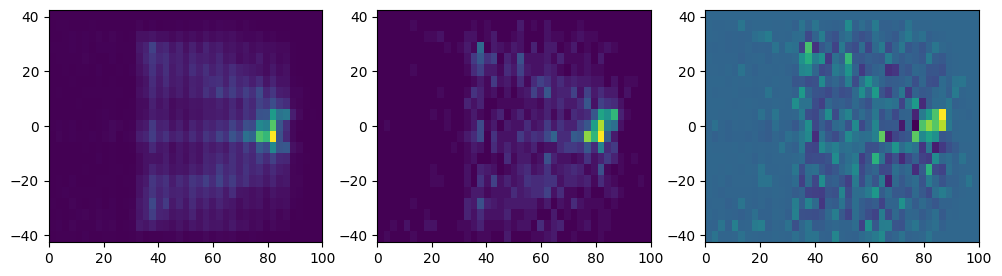

In [15]:
number_of_games_by_team = df_number_of_games_by_team.mean()

number_of_games_season = len(data_season_df['Game ID'].unique())
shots_hist2D_season_by_hour = shots_hist2D_season / (number_of_games_season*2)

number_of_games_one_team = df_number_of_games_by_team[team]
shots_hist2D_one_team_by_hour = shots_hist2D_one_team / number_of_games_one_team

fig, ax = plt.subplots(1, 3, figsize=(12,12))


ax[0].imshow(shots_hist2D_season_by_hour, extent=[x_bins[0], x_bins[-1], y_bins[0], y_bins[-1]])
ax[1].imshow(shots_hist2D_one_team_by_hour, extent=[x_bins[0], x_bins[-1], y_bins[0], y_bins[-1]])
ax[2].imshow(shots_hist2D_one_team_by_hour-shots_hist2D_season_by_hour, extent=[x_bins[0], x_bins[-1], y_bins[0], y_bins[-1]])
plt.show()


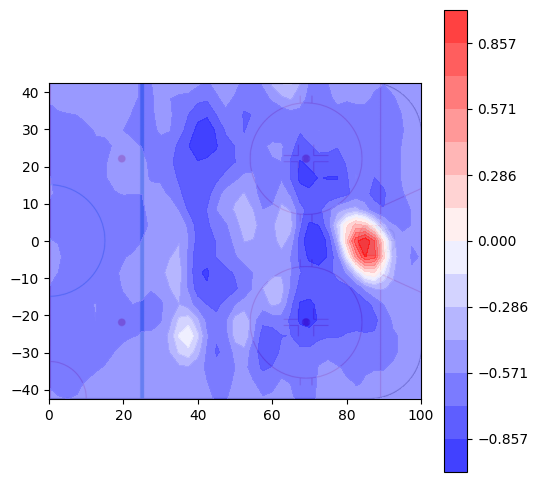

In [16]:

diff = shots_hist2D_one_team_by_hour-shots_hist2D_season_by_hour
diff = gaussian_filter(diff, sigma = 1.1)

# Normalize between -1 and 1
diff_min = diff.min()
diff_max = diff.max()
alpha = (-2./(diff_min-diff_max)) 
beta = (diff_min + diff_max) / (diff_min - diff_max)
diff_norm = alpha * diff + beta

rink_img = (255 * mpimg.imread("../figures/nhl_rink.png")).astype(int)
(h, w, c) = rink_img.shape
rink_half_img = rink_img[:, int(w/2):, :]


fig = plt.figure(figsize=(6, 6))
plt.contourf(x_bins, y_bins, diff_norm, alpha=0.8, cmap='bwr', levels = np.linspace(diff_norm.min(), diff_norm.max(), 15))
plt.colorbar(orientation = 'vertical')
plt.imshow(rink_half_img, extent=[0, 100,-42.5, 42.5])


In [17]:
num_pts_x = 50
num_pts_y = 25
[shots_hist2D_dict_diff, x_grid, y_grid] = Viz.compute_diff_shots(data_season_df, num_pts_x=num_pts_x, num_pts_y=num_pts_y)

shots_hist2D_dict_diff.keys()

dict_keys(['Anaheim Ducks (ANA)', 'Arizona Coyotes (ARI)', 'Boston Bruins (BOS)', 'Buffalo Sabres (BUF)', 'Calgary Flames (CGY)', 'Carolina Hurricanes (CAR)', 'Chicago Blackhawks (CHI)', 'Colorado Avalanche (COL)', 'Columbus Blue Jackets (CBJ)', 'Dallas Stars (DAL)', 'Detroit Red Wings (DET)', 'Edmonton Oilers (EDM)', 'Florida Panthers (FLA)', 'Los Angeles Kings (LAK)', 'Minnesota Wild (MIN)', 'Montréal Canadiens (MTL)', 'Nashville Predators (NSH)', 'New Jersey Devils (NJD)', 'New York Islanders (NYI)', 'New York Rangers (NYR)', 'Ottawa Senators (OTT)', 'Philadelphia Flyers (PHI)', 'Pittsburgh Penguins (PIT)', 'San Jose Sharks (SJS)', 'St. Louis Blues (STL)', 'Tampa Bay Lightning (TBL)', 'Toronto Maple Leafs (TOR)', 'Vancouver Canucks (VAN)', 'Vegas Golden Knights (VGK)', 'Washington Capitals (WSH)', 'Winnipeg Jets (WPG)'])


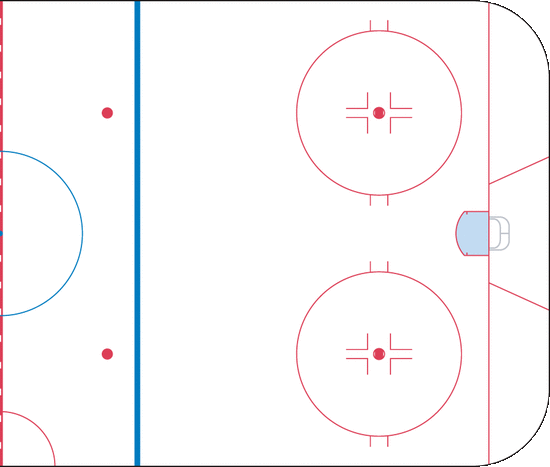


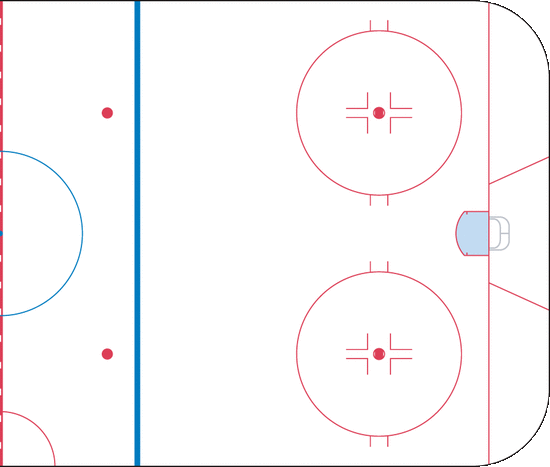

In [31]:
for season_year in range(2017, 2021):

    data_season_df = data_manager.get_season_dataframe(season_year=season_year, season_type=season_type)
    num_pts_x = 50
    num_pts_y = 25
    [shots_hist2D_dict_diff, x_grid, y_grid] = Viz.compute_diff_shots(data_season_df, num_pts_x=num_pts_x, num_pts_y=num_pts_y)
    # Create figure
    fig = go.Figure()


    rink_img = Image.open("../figures/nhl_rink.png")
    width, height = rink_img.size
    rink_half_img = rink_img.crop((width/2, 0, width, height))


    # Constants
    img_width = 800
    img_height = 400
    scale_factor = 1.0

    fig.add_trace(
        go.Contour(
            z=list(shots_hist2D_dict_diff.values())[0],
            x=x_grid,
            y=y_grid,
            colorscale="Rdbu", 
            reversescale=True,
            connectgaps=False,
            opacity=0.5,
            contours=dict(
                start=-1,
                end=1,
                size=0.2,
            )
        )
    )


    updatemenu = []
    buttons=[]
    for team in shots_hist2D_dict_diff.keys():
        buttons.append(dict(method='restyle',
                            label=team,
                            args=[{
                                'z':[shots_hist2D_dict_diff[team]],
                                'type': 'contour'}, [0]])
    
                    )

    fig.add_layout_image(
        dict(
            x=0,
            sizex=100,
            y=42.5,
            sizey=42.5*2,
            xref="x",
            yref="y",
            opacity=1.0,
            layer="below",
            sizing="stretch",
            source=rink_half_img)
    )

    fig.update_layout(
        width=img_width * scale_factor,
        height=img_height * scale_factor,
        margin={"l": 20, "r": 20, "t": 50, "b": 20},
    )

    fig.update_xaxes(
        showgrid=False,
        range=[0, 100])

    fig.update_yaxes(
        range=[-42.5, 42.5])               




    updatemenu=[]
    your_menu=dict()
    updatemenu.append(your_menu)
    updatemenu[0]['buttons']=buttons
    updatemenu[0]['direction']='down'
    updatemenu[0]['showactive']=True

    # update layout and show figure
    fig.update_layout(
        title={
            'text': f'Shots Heatmap of Season {season_year}/{season_year+1}',
            'y':0.95,
            'x':0.6,
            'xanchor': 'center',
            'yanchor': 'top'},
        xaxis_title='Distance from center line (ft)',
        yaxis_title='Distance from center of rink (ft)',
        updatemenus=updatemenu)


    fig.show()

    fig.write_html(f'../../blogpost/_includes/season_{season_year}_{season_type}.html')
